# Eval pose

In [1]:
import sys, os

class OutputInhibitor():
    def __init__(self, name=None):
        self.name = name
    def __enter__(self):
        if self.name:
            print("Launching {}... ".format(self.name), end="")
        self.ps1, self.ps2 = getattr(sys, "ps1", None), getattr(sys, "ps2", None)
        if self.ps1:
            del sys.ps1
        if self.ps2:
            del sys.ps2
        self.stderr = sys.stderr
        self.fp = open(os.devnull, "w")
        sys.stderr = self.fp
    def __exit__(self, exc_type, exc_val, exc_tb):
        if self.ps1:
            sys.ps1 = self.ps1
        if self.ps2:
            sys.ps2 = self.ps2
        sys.stderr = self.stderr
        self.fp.close()
        if self.name:
            print("Done.")


In [2]:
from mlworkflow import PickledDataset, TransformedDataset
from dataset_utilities.ds.instants_dataset import ExtractViewData, ViewCropperTransform
with OutputInhibitor():
    from openpifpaf.datasets.deepsport import AddBallSegmentationTargetViewFactory, AddBallPositionFactory

ds = PickledDataset("/scratch/gva/views_camera_with_ball2.pickle")

shape = (641,641)

ds = TransformedDataset(ds, [
    ViewCropperTransform(def_min=30, def_max=80, output_shape=shape, focus_object="player"),
])

In [38]:
from openpifpaf.datasets.constants import COCO_KEYPOINTS
from dataset_utilities.court import Court
from dataset_utilities.calib import Calib, Point2D
from collections import namedtuple
from dataset_utilities.ds.instants_dataset import PlayerAnnotation
from dataset_utilities.calib import Calib


class HiddenKeypointError(BaseException):
    pass

class Keypoints():
    def __init__(self, keypoints):
        self.keypoints = keypoints
    def __call__(self, name):
        idx = COCO_KEYPOINTS.index(name)
        if self.keypoints[idx*3+2] != 2:
            raise HiddenKeypointError
        return namedtuple(name, ["x", "y"])(*self.keypoints[idx*3:idx*3+2])
    def all(self):
        return [self(name) for name in COCO_KEYPOINTS[0:17]]

class PlayerSkeleton():
    def __init__(self, keypoints, category_id, score, bbox, cifhr):
        n_keypoints = len(keypoints)//3
        assert all(keypoints[idx*3+0] == keypoints[idx*3+1] == 0 for idx in range(n_keypoints) if keypoints[idx*3+2] != 2)
        self.keypoints = Keypoints(keypoints)
        self.category_id = category_id
        self.score = score
        self.bbox = bbox
        self.cifhr = cifhr
    @property
    def head(self):
        l_ear = self.keypoints('left_ear')
        r_ear = self.keypoints('right_ear')
        return (Point2D(l_ear.x, l_ear.y) + Point2D(r_ear.x, r_ear.y))/2
    @property
    def hips(self):
        l_hip = self.keypoints('left_hip')
        r_hip = self.keypoints('right_hip')
        return (Point2D(l_hip.x, l_hip.y) + Point2D(r_hip.x, r_hip.y))/2
    @property
    def foot1(self):
        l_ankle = self.keypoints('left_ankle')
        return Point2D(l_ankle.x, l_ankle.y)
    @property
    def foot2(self):
        r_ankle = self.keypoints('right_ankle')
        return Point2D(r_ankle.x, r_ankle.y)
    @property
    def visible(self):
        for name in ["head", "hips", "foot1", "foot2"]:
            try:
                getattr(self, name)
            except HiddenKeypointError:
                continue
            return True
        else:
            return False
    def projects_in_court(self, calib: Calib, court: Court):
        MARGIN = 10
        min_y = min_x = -MARGIN
        max_x = court.w + MARGIN
        max_y = court.h + MARGIN
        for foot in ["foot1", "foot2"]:
            try:
                foot = calib.project_2D_to_3D(getattr(self, foot), Z=10) # assumed at 10 cm above the court
                if min_x < foot.x < max_x and min_y < foot.y < max_y:
                    return True
            except HiddenKeypointError:
                continue
        return False
    @property
    def confidence(self):
        acc = 0
        for idx, name in enumerate(COCO_KEYPOINTS[0:17]):
            try:
                kp = self.keypoints(name)
                acc += self.cifhr[idx, int(kp.y), int(kp.x)]
            except HiddenKeypointError:
                continue
        return acc/17

class PlayerAnnotation2D():
    def __init__(self, annotation: PlayerAnnotation, calib: Calib):
        self.annotation = annotation
        self.calib = calib
    @property
    def head(self):
        return self.calib.project_3D_to_2D(self.annotation.head)
    @property
    def hips(self):
        return self.calib.project_3D_to_2D(self.annotation.hips)
    @property
    def foot1(self):
        return self.calib.project_3D_to_2D(self.annotation.foot1)
    @property
    def foot2(self):
        return self.calib.project_3D_to_2D(self.annotation.foot2)

In [40]:
KiHEAD = 0.2
KiHIPS = 0.5
KiFEET = 0.1

def dist(p1, p2):
    return np.sqrt(np.sum((p1-p2)**2))

def mOKS(a: PlayerAnnotation2D, p: PlayerSkeleton):
    def OKS(a, p, name, kapa, s):
        try: 
            return np.exp(-dist(getattr(a, name), getattr(p, name))/(2*s*kapa**2))
        except HiddenKeypointError:
            return np.nan
    
    keypoints = Point2D([a.head, a.hips, a.foot1, a.foot2])
    s = (np.max(keypoints.x)-np.min(keypoints.x))*(np.max(keypoints.y)-np.min(keypoints.y)) # BB area

    pair1 = np.nanmean([OKS(a, p, "head", KiHEAD, s), OKS(a, p, "hips", KiHIPS, s), OKS(a, p, "foot1", KiFEET, s), OKS(a, p, "foot2", KiFEET, s)])
    pair2 = np.nanmean([OKS(a, p, "head", KiHEAD, s), OKS(a, p, "hips", KiHIPS, s), OKS(a, p, "foot2", KiFEET, s), OKS(a, p, "foot1", KiFEET, s)])
    return min(pair1, pair2)

In [54]:
%matplotlib inline
import pickle
from tqdm.notebook import tqdm
from openpifpaf.predict import main
import sys
import imageio
import numpy as np
import json
from matplotlib import pyplot as plt
import matplotlib
matplotlib.pyplot.ion()
from ipywidgets import Output
from IPython import display

import cv2

output = Output()
display.display(output)

weights_file = "resnet50-210224-145256-cifcent-pan-20fee226.pkl"

combined_results = {}
keys = list(ds.keys.all())
import random
random.shuffle(keys)
for key in tqdm(keys):
    view = ds.query_item(key)
    if not view:
        continue
    filename = "/home/gva/test_pose.png"
    imageio.imwrite(filename, view.image)
    sys.argv = [
        "aue",
        filename,
        "--checkpoint", f"/home/gva/poseestimation_emb/results/{weights_file}",
        "--image-output",
        "--debug-images", "--debug-cif-c", "--debug", "--json-output"
    ]

    with OutputInhibitor():
        main()
    court = Court(view.rule_type)
    cifhr = pickle.load(open("/home/gva/pifhr.pickle","rb"))
    
    predictions = [PlayerSkeleton(**p, cifhr=cifhr) for p in json.load(open("/home/gva/test_pose.png.predictions.json", "r"))]
    predictions = [p for p in predictions if p.projects_in_court(view.calib, court) and p.visible]
    annotations = [PlayerAnnotation2D(a, view.calib) for a in view.annotations if a.type == "player" and a.camera == key.camera]
    if not predictions or not annotations:
        continue

    oks_list = []
    matching = {}
    for p in sorted(predictions, key=lambda p: p.confidence, reverse=True):
        idx = np.argmax([mOKS(a, p) for a in annotations])
        matching[p] = annotations[idx]
        oks_list.append(mOKS(annotations[idx], p))
        #del annotations[idx]
    print(oks_list)
    break


Output()

  0%|          | 0/1680 [00:00<?, ?it/s]

[0.9808590200707888, 0.8503645275668202, 0.9129126886432777]


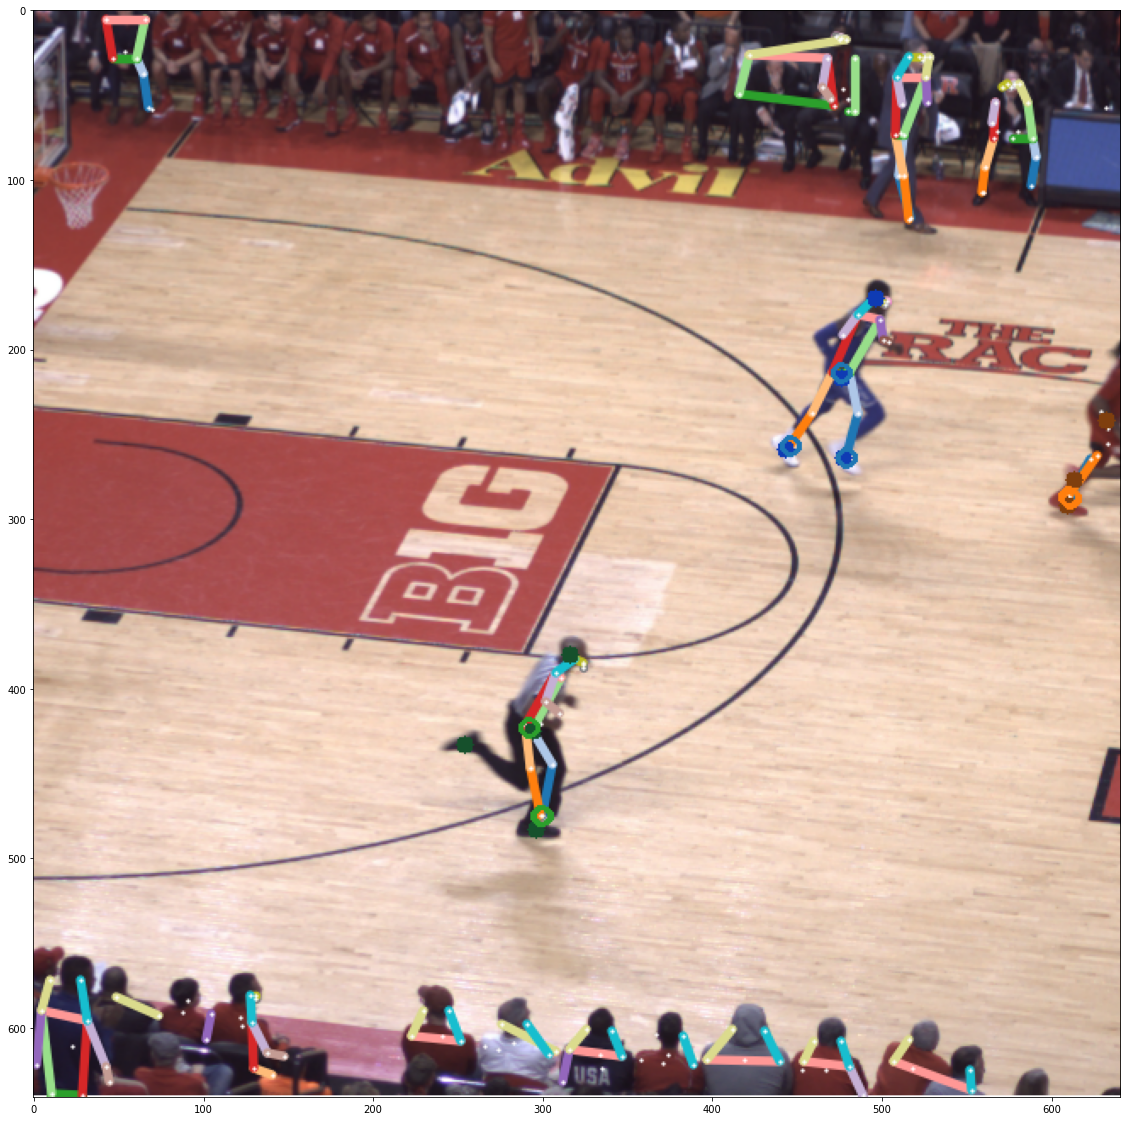

In [55]:
%matplotlib inline
import matplotlib;
import imageio

colors = [tuple(int(round(v*255)) for v in matplotlib.colors.to_rgb(c)) for c in matplotlib.pyplot.rcParams['axes.prop_cycle'].by_key()['color']]
img = np.array(imageio.imread("/home/gva/test_pose.png.predictions.png")[...,0:3])

for p, c in zip(predictions, colors):
    for name in ["head", "hips", "foot1", "foot2"]:
        try:
            a = matching[p]
            cv2.circle(img, (int(getattr(a, name).x), int(getattr(a, name).y)), 5, (c[0]//2, c[1]//2, c[2]), -1)
            cv2.circle(img, (int(getattr(p, name).x), int(getattr(p, name).y)), 5, c, 2)
        except HiddenKeypointError:
            pass

plt.figure(figsize=(20,20)).gca().imshow(img)

In [ ]:
print(cifhr.shape) # 641x641

In [ ]:
%matplotlib inline
print([p.confidence for p in predictions])

In [ ]:
while distances.size:
    print(distances)
    ip, ia = np.unravel_index(distances.argmin(), distances.shape)
    distances = np.delete(distances, ip, 0)
    distances = np.delete(distances, ia, 1)
print(distances)

In [ ]:
%matplotlib inline
plt.imshow(view.image)

In [ ]:
import json

d = json.load(open("/home/gva/test_pose.png.predictions.json", "r"))
print(len(d[0]["keypoints"]))

In [ ]:
plt.imshow(view.draw())

In [ ]:
break
    distances = np.zeros((len(predictions), len(annotations)))
    for ip, p in enumerate(predictions):
        for ia, a in enumerate(annotations):
            distances[ip, ia] = mse(view.calib, a, p)
    oks_list = []
    while distances:
        ip, ia = np.unravel_index(distances.argmin(), distances.shape)
        oks_list.append(oks(predictions[ip], annotations[ia]))
        distances = np.delete(distances, ip, 0)
        distances = np.delete(distances, ia, 1)